# Download data from MNIST
We download data from an online source(deeplearning.net) to local directory.
The data is deserialized using pickle into tuples for train / test

In [4]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [27]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f)

In [28]:
print ("Training set shape, x_train = {}, y_train = {}".format(x_train.shape, y_train.shape))

Training set shape, x_train = (50000, 784), y_train = (50000,)


In [29]:
print ("Validation set shape, x_valid = {}, y_valid = {}".format(x_valid.shape, y_valid.shape))

Validation set shape, x_valid = (10000, 784), y_valid = (10000,)


In [30]:
print ("Test set shape, x_test = {}, y_test = {}".format(x_test.shape, y_test.shape))

Test set shape, x_test = (10000, 784), y_test = (10000,)


# Display input with label
In this section we write some utils to display input with labels

In [77]:
import matplotlib.pyplot as plt
import torch

In [53]:
def display_example(x_train, y_train, N=0):
    plt.imshow(x_train[N].reshape((28, 28)), cmap="gray")
    plt.title("digit label = {}".format(y_train[N]))

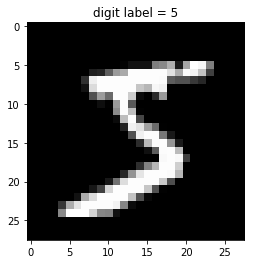

In [54]:
display_example(x_train, y_train)

In [55]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

In [58]:
n, c = x_train.shape
print("Training set has {} examples with {} features each".format(n,c))
print("Training labels are in range [{}, {}]".format(y_train.min(), y_train.max()))

Training set has 50000 examples with 784 features each
Training labels are in range [0, 9]


## NN from scrath
In this section, we implement a neural network without torch.nn
using basic torch tensors

In [128]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [140]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb, weights, bias):
#    return log_softmax(xb @ weights + bias)
    return log_softmax(xb.mm(weights) + bias)

In [130]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [141]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb, weights, bias)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

(tensor([ -9.6709, -14.7251,  -8.9294,  -1.4262, -15.9069,  -0.2758, -11.7755,
         -7.6929,  -9.6340,  -9.9914], grad_fn=<SelectBackward>), torch.Size([64, 10]))


In [142]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(0.1890, grad_fn=<NegBackward>)


In [143]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [144]:
print(accuracy(preds, yb))

tensor(0.9219)


In [160]:
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

with torch.no_grad():
    print ("Accuracy on training on initial weights = {}%%".
           format(loss_func(model(x_train, weights, bias), y_train), 100*accuracy(model(x_train, weights, bias), y_train)))
    print ("Accuracy on validation  on initial weights = {}%%".
           format( loss_func(model(x_valid, weights, bias), y_valid), 100*accuracy(model(x_valid, weights, bias), y_valid)))

lr = 0.5
bs = 64
epochs = 5
for e in range(epochs):
    for i in range (n/bs):
        xb = x_train[i*bs:min(n, (i+1)*bs)]  # a mini-batch from x
        yb = y_train[i*bs:min(n, (i+1)*bs)]
        preds = model(xb, weights, bias)  # predictions
        loss = loss_func(preds, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

    with torch.no_grad():
        print ("Accuracy on training after epoch#{}, loss = {}, acc = {}%%".
               format(e, loss_func(model(x_train, weights, bias), y_train), 100*accuracy(model(x_train, weights, bias), y_train)))
        print ("Accuracy on validation after epoch#{}, loss = {}, acc = {}%%".
               format(e, loss_func(model(x_valid, weights, bias), y_valid), 100*accuracy(model(x_valid, weights, bias), y_valid)))
    #    weights = weights - learning_rate * weights.grad
    #    bias = bias - learning_rate * bias.grad

Accuracy on training on initial weights = 2.3849799633%%
Accuracy on validation  on initial weights = 2.38120532036%%
Accuracy on training after epoch#0, loss = 0.324643403292, acc = 90.6359939575%%
Accuracy on validation after epoch#0, loss = 0.306144207716, acc = 91.3399963379%%
Accuracy on training after epoch#1, loss = 0.305484950542, acc = 91.2080001831%%
Accuracy on validation after epoch#1, loss = 0.292917281389, acc = 91.8299942017%%
Accuracy on training after epoch#2, loss = 0.296874523163, acc = 91.5120010376%%
Accuracy on validation after epoch#2, loss = 0.288196325302, acc = 91.9199981689%%
Accuracy on training after epoch#3, loss = 0.291536957026, acc = 91.6459960938%%
Accuracy on validation after epoch#3, loss = 0.2859634161, acc = 91.9499969482%%
Accuracy on training after epoch#4, loss = 0.287716329098, acc = 91.7740020752%%
Accuracy on validation after epoch#4, loss = 0.284799307585, acc = 92.0199966431%%


# Refactor using torch.nn.functional
In this section we refactor our above code and use functional package

In [161]:
import torch.nn.functional as F

In [162]:
loss_func = F.cross_entropy
def forward(xb, weights, bias):
    return xb.mm(weights) + bias

In [164]:
with torch.no_grad():
    print(loss_func(forward(x_valid, weights, bias), y_valid), accuracy(forward(x_valid, weights, bias), y_valid))

(tensor(0.2848), tensor(0.9202))


# Train using functional package
We repeat same exercise using functional package. Try to implement everything on your own

In [175]:
w = torch.randn(784, 10) / math.sqrt(784.0)
w.requires_grad_()
b = torch.zeros(10, requires_grad=True)

with torch.no_grad():
    print(loss_func(forward(x_valid, w, b), y_valid), accuracy(forward(x_valid, w, b), y_valid))

with torch.no_grad():
    print ("Accuracy on training on initial weights = {}%%".
           format(loss_func(model(x_train, weights, bias), y_train), 100*accuracy(model(x_train, weights, bias), y_train)))
    print ("Accuracy on validation  on initial weights = {}%%".
           format( loss_func(model(x_valid, weights, bias), y_valid), 100*accuracy(model(x_valid, weights, bias), y_valid)))

    
lr = 0.5
epochs = 10
bs = 64
for e in range(epochs):
    for i in range(n/bs):
        b_start = i*bs
        b_end = min(n, (i+1)*bs)
        xb = x_train[b_start:b_end]
        yb = y_train[b_start:b_end]
        pred = forward(xb, w, b)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            w -= w.grad*lr
            b -= b.grad*lr
            w.grad.zero_()
            b.grad.zero_()
    
    with torch.no_grad():
        print ("Accuracy on training after epoch#{}, loss = {}, acc = {}%%".
               format(e, loss_func(model(x_train, weights, bias), y_train), 100*accuracy(model(x_train, weights, bias), y_train)))
        print ("Accuracy on validation after epoch#{}, loss = {}, acc = {}%%".
               format(e, loss_func(model(x_valid, weights, bias), y_valid), 100*accuracy(model(x_valid, weights, bias), y_valid)))

(tensor(2.3528), tensor(0.0957))
Accuracy on training on initial weights = 0.287716329098%%
Accuracy on validation  on initial weights = 0.284799307585%%
Accuracy on training after epoch#0, loss = 0.287716329098, acc = 91.7740020752%%
Accuracy on validation after epoch#0, loss = 0.284799307585, acc = 92.0199966431%%
Accuracy on training after epoch#1, loss = 0.287716329098, acc = 91.7740020752%%
Accuracy on validation after epoch#1, loss = 0.284799307585, acc = 92.0199966431%%
Accuracy on training after epoch#2, loss = 0.287716329098, acc = 91.7740020752%%
Accuracy on validation after epoch#2, loss = 0.284799307585, acc = 92.0199966431%%
Accuracy on training after epoch#3, loss = 0.287716329098, acc = 91.7740020752%%
Accuracy on validation after epoch#3, loss = 0.284799307585, acc = 92.0199966431%%
Accuracy on training after epoch#4, loss = 0.287716329098, acc = 91.7740020752%%
Accuracy on validation after epoch#4, loss = 0.284799307585, acc = 92.0199966431%%
Accuracy on training after

# Use nn module
Now we use nn.module to encapsulate the model

In [176]:
import torch.nn as nn

In [189]:
from torch import nn
class MnistLogistic(nn.Module):
    def __init__(self):
        super(MnistLogistic, self).__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb.mm(self.weights) + self.bias

In [194]:
def fit(model, x_train, y_train, x_valid, y_valid, bs = 64, lr = 0.5):
    n, num_feats = x_train.shape
    with torch.no_grad():
        print ("Accuracy on training on initial weights = {}%%".
               format(loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
        print ("Accuracy on validation  on initial weights = {}%%".
               format( loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))
    
    for e in range(epochs):
        for i in range(n/bs):
            b_start = i*bs
            b_end = min(n, (i+1)*bs)
            xb = x_train[b_start:b_end]
            yb = y_train[b_start:b_end]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        
        with torch.no_grad():
            print ("Accuracy on training after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
            print ("Accuracy on validation after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))

In [195]:
model = MnistLogistic()
fit(model, x_train, y_train, x_valid, y_valid)

Accuracy on training on initial weights = 2.40425419807%%
Accuracy on validation  on initial weights = 2.40479540825%%
Accuracy on training after epoch#0, loss = 0.325196832418, acc = 90.6240005493%%
Accuracy on validation after epoch#0, loss = 0.306496471167, acc = 91.3099975586%%
Accuracy on training after epoch#1, loss = 0.305829912424, acc = 91.2140045166%%
Accuracy on validation after epoch#1, loss = 0.293144583702, acc = 91.8199996948%%
Accuracy on training after epoch#2, loss = 0.297110497952, acc = 91.513999939%%
Accuracy on validation after epoch#2, loss = 0.288365244865, acc = 91.9599990845%%
Accuracy on training after epoch#3, loss = 0.291716247797, acc = 91.6580047607%%
Accuracy on validation after epoch#3, loss = 0.286115825176, acc = 92.0199966431%%
Accuracy on training after epoch#4, loss = 0.287865579128, acc = 91.7480010986%%
Accuracy on validation after epoch#4, loss = 0.284949570894, acc = 92.0699996948%%
Accuracy on training after epoch#5, loss = 0.284887582064, acc

In [196]:
from torch import nn
class MnistLogisticB(nn.Module):
    def __init__(self):
        super(MnistLogisticB, self).__init__()
        self.fc1 = nn.Linear(784, 10)
    
    def forward(self, xb):
        return self.fc1(xb)

In [197]:
modelB = MnistLogisticB()
fit(model, x_train, y_train, x_valid, y_valid)

Accuracy on training on initial weights = 0.277150541544%%
Accuracy on validation  on initial weights = 0.284150838852%%
Accuracy on training after epoch#0, loss = 0.275786787271, acc = 92.0780029297%%
Accuracy on validation after epoch#0, loss = 0.284346610308, acc = 92.1199951172%%
Accuracy on training after epoch#1, loss = 0.274560540915, acc = 92.1039962769%%
Accuracy on validation after epoch#1, loss = 0.284584701061, acc = 92.1500015259%%
Accuracy on training after epoch#2, loss = 0.273445546627, acc = 92.1299972534%%
Accuracy on validation after epoch#2, loss = 0.284852355719, acc = 92.1399993896%%
Accuracy on training after epoch#3, loss = 0.272421598434, acc = 92.1500015259%%
Accuracy on validation after epoch#3, loss = 0.285141736269, acc = 92.1399993896%%
Accuracy on training after epoch#4, loss = 0.27148270607, acc = 92.1760025024%%
Accuracy on validation after epoch#4, loss = 0.285443007946, acc = 92.0999984741%%
Accuracy on training after epoch#5, loss = 0.270608127117, a

# Use optim module
Now we make use of Adam optimizer from optim module and use it instead of manually updaing the parameters

In [198]:
from torch import optim

In [199]:
modelB2 = MnistLogisticB()
optimizer = optim.SGD(modelB2.parameters(), lr=0.1)

In [200]:
def fitB(model, opt, x_train, y_train, x_valid, y_valid, bs = 64):
    n, num_feats = x_train.shape
    with torch.no_grad():
        print ("Accuracy on training on initial weights = {}%%".
               format(loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
        print ("Accuracy on validation  on initial weights = {}%%".
               format( loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))
    
    for e in range(epochs):
        for i in range(n/bs):
            b_start = i*bs
            b_end = min(n, (i+1)*bs)
            xb = x_train[b_start:b_end]
            yb = y_train[b_start:b_end]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                opt.step()
                opt.zero_grad()
        
        with torch.no_grad():
            print ("Accuracy on training after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
            print ("Accuracy on validation after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))

In [201]:
fitB(modelB2, optimizer, x_train, y_train, x_valid, y_valid)

Accuracy on training on initial weights = 2.3481528759%%
Accuracy on validation  on initial weights = 2.35114264488%%
Accuracy on training after epoch#0, loss = 0.370350301266, acc = 89.641998291%%
Accuracy on validation after epoch#0, loss = 0.339498013258, acc = 90.7799987793%%
Accuracy on training after epoch#1, loss = 0.331948369741, acc = 90.6699981689%%
Accuracy on validation after epoch#1, loss = 0.308653444052, acc = 91.5299987793%%
Accuracy on training after epoch#2, loss = 0.314577966928, acc = 91.1580047607%%
Accuracy on validation after epoch#2, loss = 0.295205026865, acc = 91.7599945068%%
Accuracy on training after epoch#3, loss = 0.304036706686, acc = 91.439994812%%
Accuracy on validation after epoch#3, loss = 0.287277877331, acc = 91.9199981689%%
Accuracy on training after epoch#4, loss = 0.296733736992, acc = 91.6980056763%%
Accuracy on validation after epoch#4, loss = 0.281948834658, acc = 92.0799942017%%
Accuracy on training after epoch#5, loss = 0.291266262531, acc =

## Use dataset
Now we implement a dataset to provide an iterator on mini-batches of mnist

In [207]:
from torch.utils.data import TensorDataset

In [212]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
modelB3 = MnistLogisticB()
optimizer = optim.SGD(modelB3.parameters(), lr=0.1)

In [213]:
def fitC(model, opt, train_ds, valid_ds, bs = 64):
    n, num_feats = x_train.shape
    with torch.no_grad():
        print ("Accuracy on training on initial weights = {}%%".
               format(loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
        print ("Accuracy on validation  on initial weights = {}%%".
               format( loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))
    
    for e in range(epochs):
        for i in range(n/bs):
            b_start = i*bs
            b_end = min(n, (i+1)*bs)
            xb, yb = train_ds[b_start:b_end]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                opt.step()
                opt.zero_grad()
        
        with torch.no_grad():
            print ("Accuracy on training after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
            print ("Accuracy on validation after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))

In [214]:
fitC(modelB3, optimizer, train_ds, valid_ds)

Accuracy on training on initial weights = 2.30613493919%%
Accuracy on validation  on initial weights = 2.30903148651%%
Accuracy on training after epoch#0, loss = 0.370242625475, acc = 89.5859985352%%
Accuracy on validation after epoch#0, loss = 0.339536756277, acc = 90.8399963379%%
Accuracy on training after epoch#1, loss = 0.331855386496, acc = 90.6979980469%%
Accuracy on validation after epoch#1, loss = 0.308734446764, acc = 91.5499954224%%
Accuracy on training after epoch#2, loss = 0.314504891634, acc = 91.1660003662%%
Accuracy on validation after epoch#2, loss = 0.295303970575, acc = 91.7299957275%%
Accuracy on training after epoch#3, loss = 0.303981512785, acc = 91.4759979248%%
Accuracy on validation after epoch#3, loss = 0.287387877703, acc = 91.9499969482%%
Accuracy on training after epoch#4, loss = 0.296696424484, acc = 91.7119979858%%
Accuracy on validation after epoch#4, loss = 0.282062709332, acc = 92.0799942017%%
Accuracy on training after epoch#5, loss = 0.29124084115, acc

# Refactor using dataLoader
Now we move from dataset to dataloader

In [215]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [217]:
def fitC(model, opt, train_dl, valid_ds, bs = 64):
    n, num_feats = x_train.shape
    with torch.no_grad():
        print ("Accuracy on training on initial weights = {}%%".
               format(loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
        print ("Accuracy on validation  on initial weights = {}%%".
               format( loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))
    
    for e in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                opt.step()
                opt.zero_grad()
        
        with torch.no_grad():
            print ("Accuracy on training after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_train), y_train), 100*accuracy(model(x_train), y_train)))
            print ("Accuracy on validation after epoch#{}, loss = {}, acc = {}%%".
                   format(e, loss_func(model(x_valid), y_valid), 100*accuracy(model(x_valid), y_valid)))

In [218]:
modelB4 = MnistLogisticB()
optimizer = optim.SGD(modelB4.parameters(), lr=0.1)

In [219]:
fitC(modelB4, optimizer, train_dl, valid_ds)

Accuracy on training on initial weights = 2.31860256195%%
Accuracy on validation  on initial weights = 2.31980133057%%
Accuracy on training after epoch#0, loss = 0.373152822256, acc = 89.5219955444%%
Accuracy on validation after epoch#0, loss = 0.340128093958, acc = 90.7900009155%%
Accuracy on training after epoch#1, loss = 0.333486914635, acc = 90.6159973145%%
Accuracy on validation after epoch#1, loss = 0.308661967516, acc = 91.6100006104%%
Accuracy on training after epoch#2, loss = 0.315741688013, acc = 91.1399993896%%
Accuracy on validation after epoch#2, loss = 0.295146524906, acc = 91.8299942017%%
Accuracy on training after epoch#3, loss = 0.305053055286, acc = 91.4720001221%%
Accuracy on validation after epoch#3, loss = 0.287260949612, acc = 91.9899978638%%
Accuracy on training after epoch#4, loss = 0.297685474157, acc = 91.702003479%%
Accuracy on validation after epoch#4, loss = 0.281992733479, acc = 92.0599975586%%
Accuracy on training after epoch#5, loss = 0.292188853025, acc

In [220]:
print(loss_func(modelB4(xb), yb))

tensor(0.2079, grad_fn=<NllLossBackward>)


# Final concise model training code
Now we have a few simple for loops using iterable dataloaders, optimizer and a train/validation dataset.
The code is very small and boilderplate

In [238]:
import numpy as np

In [239]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.sum(), len(xb)

In [246]:
def fitModel(model, optimizer, train_dl, valid_dl, epochs):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, F.cross_entropy, xb, yb, optimizer)
        
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, F.cross_entropy, xb, yb) for xb, yb in valid_dl])
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(epoch, val_loss)

In [247]:
modelB5 = MnistLogisticB()
optimizer = optim.SGD(modelB5.parameters(), lr=0.1)

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs)

In [248]:
fitModel(modelB5, optimizer, train_dl, valid_dl, 20)

(0, 0.34033641529083253)
(1, 0.3088694522857666)
(2, 0.29537068300247193)
(3, 0.28749094414710996)
(4, 0.2822225090503693)
(5, 0.27841439590454103)
(6, 0.2755183416366577)
(7, 0.27323586492538454)
(8, 0.27138883476257325)
(9, 0.26986349115371705)
(10, 0.26858336753845213)
(11, 0.26749494862556455)
(12, 0.2665594666481018)
(13, 0.26574814367294314)
(14, 0.2650391053199768)
(15, 0.26441534366607666)
(16, 0.263863587808609)
(17, 0.26337311162948607)
(18, 0.26293529777526853)
(19, 0.26254311027526855)


# Change to a convolutional neural network
So far we have been using a simple FFNN for our training on MNIST.
Now we use a convolutional neural network for the same task

In [253]:
class MNISTCnnModel(nn.Module):
    def __init__(self):
        super(MNISTCnnModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

In [254]:
cnnModel = MNISTCnnModel()
optimizer = optim.SGD(cnnModel.parameters(), lr=0.1)

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs)

fitModel(cnnModel, optimizer, train_dl, valid_dl, 20)

(0, 1.5300308917999268)
(1, 1.0817527778625489)
(2, 0.7931236612319946)
(3, 0.7176864025115967)
(4, 0.6169787571907044)
(5, 0.5826909749984741)
(6, 0.5240694478988648)
(7, 0.4413734820365906)
(8, 0.3488052159309387)
(9, 0.3560064856529236)
(10, 0.3631133273124695)
(11, 0.35982017002105715)
(12, 0.31815854501724244)
(13, 0.29408917407989504)
(14, 0.2923297614097595)
(15, 0.28027480754852296)
(16, 0.27282418813705445)
(17, 0.26235407552719114)
(18, 0.24567805786132813)
(19, 0.2426101110458374)


In [255]:
fitModel(cnnModel, optimizer, train_dl, valid_dl, 20)

(0, 0.23126391363143922)
(1, 0.22287462797164917)
(2, 0.2140595742225647)
(3, 0.20798238687515258)
(4, 0.20223542881011963)
(5, 0.19704772806167603)
(6, 0.19249215593338012)
(7, 0.1886595329284668)
(8, 0.1839370771408081)
(9, 0.18066054000854492)
(10, 0.17819957342147827)
(11, 0.1769318013191223)
(12, 0.1747707197189331)
(13, 0.173764244556427)
(14, 0.17264201068878174)
(15, 0.17211034574508666)
(16, 0.17050830821990967)
(17, 0.16735441493988037)
(18, 0.16500684146881103)
(19, 0.1633652871131897)


In [264]:
print ("Accuracy on validation set is : %0.2f%%" % (100* accuracy(cnnModel(x_valid), y_valid).item()))

Accuracy on validation set is : 95.13%


In [265]:
fitModel(cnnModel, optimizer, train_dl, valid_dl, 20)
print ("Accuracy on validation set is : %0.2f%%" % (100* accuracy(cnnModel(x_valid), y_valid).item()))

(0, 0.1602298047065735)
(1, 0.1580078477859497)
(2, 0.15567488374710084)
(3, 0.1544105640411377)
(4, 0.15261572389602662)
(5, 0.15069404430389405)
(6, 0.14867582902908325)
(7, 0.14723446893692016)
(8, 0.14615018939971924)
(9, 0.145003698348999)
(10, 0.14369693126678468)
(11, 0.1420660517692566)
(12, 0.14021934061050415)
(13, 0.13885206813812256)
(14, 0.13716021308898926)
(15, 0.13581849250793457)
(16, 0.13432721633911132)
(17, 0.13316046733856202)
(18, 0.13259186248779298)
(19, 0.13140884065628053)
Accuracy on validation set is : 96.04%
